<a href="https://colab.research.google.com/github/markub3327/OpenAI-CarRacing-RNN/blob/master/CarRacing_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare & install required libraries

When we would like to run it in Google Colab, we need to download dependencies before running.

In [ ]:
!git clone https://github.com/markub3327/OpenAI-CarRacing-RNN.git
%cd OpenAI-CarRacing-RNN/
%ls

In [ ]:
!pip3 install wandb

# Importing needed libaries

In [ ]:
import os
import numpy as np
import wandb

from nets.agent import Agent
from wandb.keras import WandbCallback 

# Dataset

This class prepare datasets for training:

1.   prepare timesteps (4 frames),
2.   shuffle data to prevent not fitting the model,

This is like a pipeline for the training process, where are datasets loaded from disk and preprocessed before the training starts.



In [ ]:
class Dataset:
    def __init__(self, path='data/', timesteps=4):
        # the list of datasets
        self.dat = []
        self.ptr = 0
        self.timesteps = timesteps

        # scan datasets
        with os.scandir(path) as entries:
            for entry in entries:
                self.dat.append(entry.path)
    
    def _read_dataset(self, path):        
        with np.load(path) as data:
            f = data['frames']
            a = data['actions']
            print(f.shape)
            print(a.shape)

            # make timesteps
            f, a = self._make_timesteps(f, a)
            print(f.shape)
            print(a.shape)

            # shuffle dataset after loading from file
            f, a = self._shuffle_dataset(f, a)
        
        print(f"Loaded dataset from: {path}")

        return f, a

    def _make_timesteps(self, f_dat, a_dat):
        # generate random indexes
        rand_idxs = np.arange(self.timesteps + 1, f_dat.shape[0], dtype=np.int)
        print(rand_idxs)
        print(rand_idxs.shape)

        states = np.zeros((rand_idxs.shape[0], self.timesteps) + f_dat.shape[1:], dtype=np.uint8)
            
        for i, idx in enumerate(rand_idxs):
            states[i] = f_dat[idx-self.timesteps-1:idx-1]

        return states, a_dat[rand_idxs]
        
    def _shuffle_dataset(self, f_dat, a_dat):
        idx = np.arange(0, f_dat.shape[0], dtype=np.int)
        print(idx)
        np.random.shuffle(idx)
        print(idx)

        return f_dat[idx], a_dat[idx]

    def __iter__(self):
        self.ptr = 0
        return self

    def __next__(self):
        if self.ptr == len(self.dat):
           raise StopIteration
        s, a = self._read_dataset(self.dat[self.ptr])
        self.ptr = self.ptr + 1
        return s, a

# The main training function

In [ ]:
def Training(hid=[32, 64], num_frames=4):

    wandb.init(project="car_racing")

    # create network
    agent = Agent()
    agent.create((num_frames, 96, 96, 3), hid=hid)

    # save model's plot
    agent.save_plot()
    
    # load datasets from folder
    dataset = Dataset(timesteps=num_frames)

    # take every dataset from folder
    for s, a in dataset:
        print('+-----------------------------------------------+')

        print('Run training...')
        print('|-----------------------------------------------|')
        agent.train(s, a, epochs=1000, top_only=True, callbacks=[WandbCallback()])
        
        print('Run fine-tuning...')
        print('|-----------------------------------------------|')
        agent.train(s, a, epochs=1000, top_only=False, callbacks=[WandbCallback()])

        print('+-----------------------------------------------+')

    # save model
    agent.save()

# Run training

In [ ]:
Training()

# Results

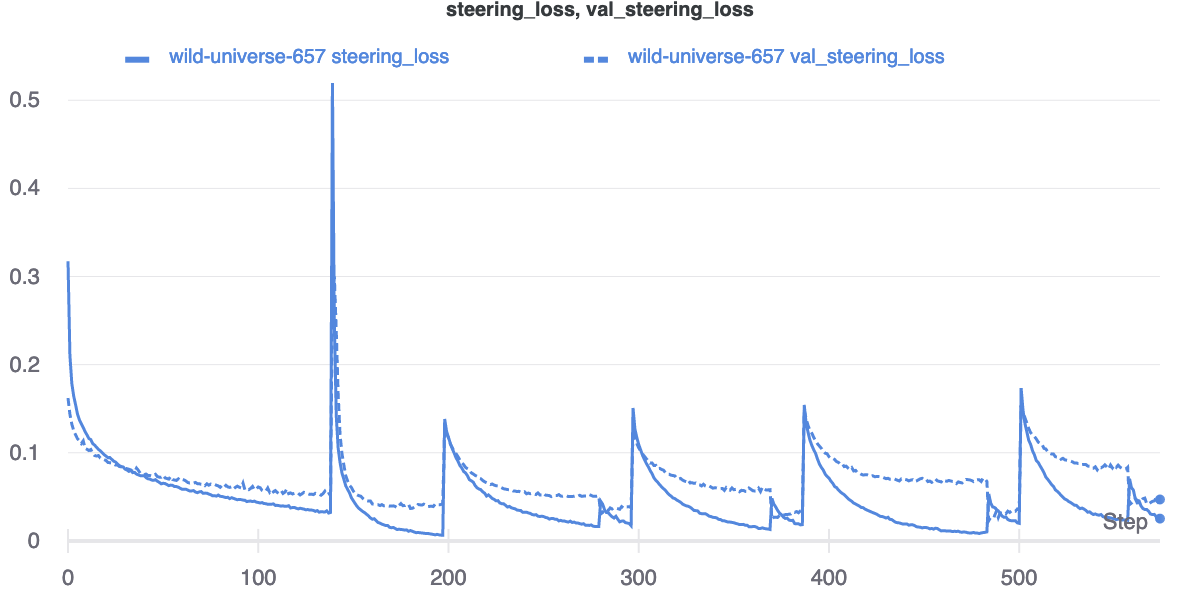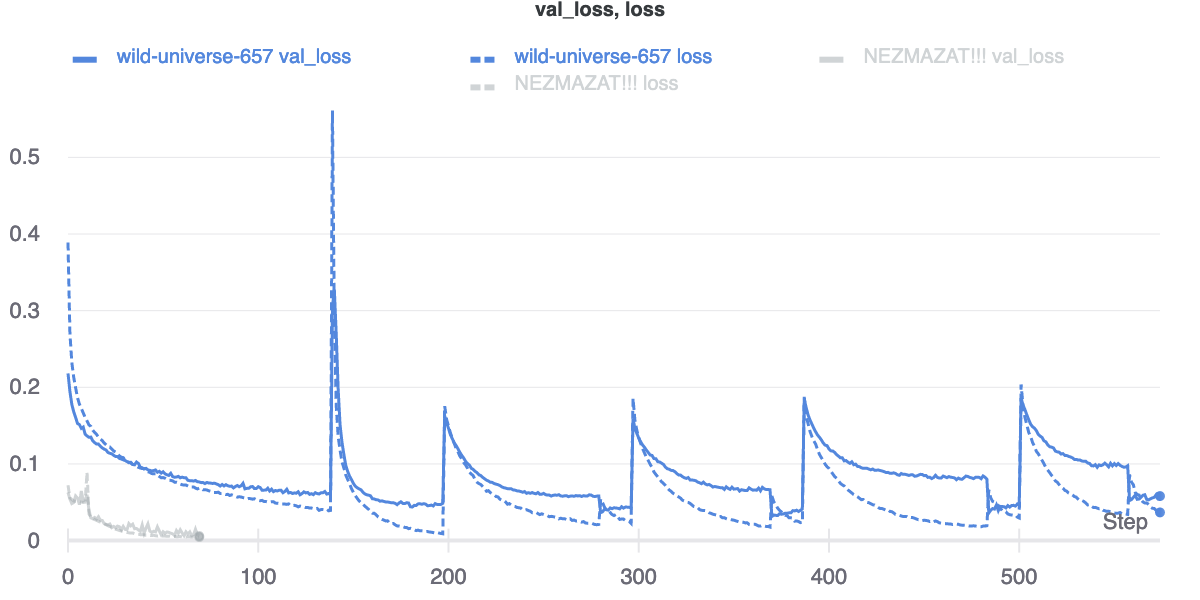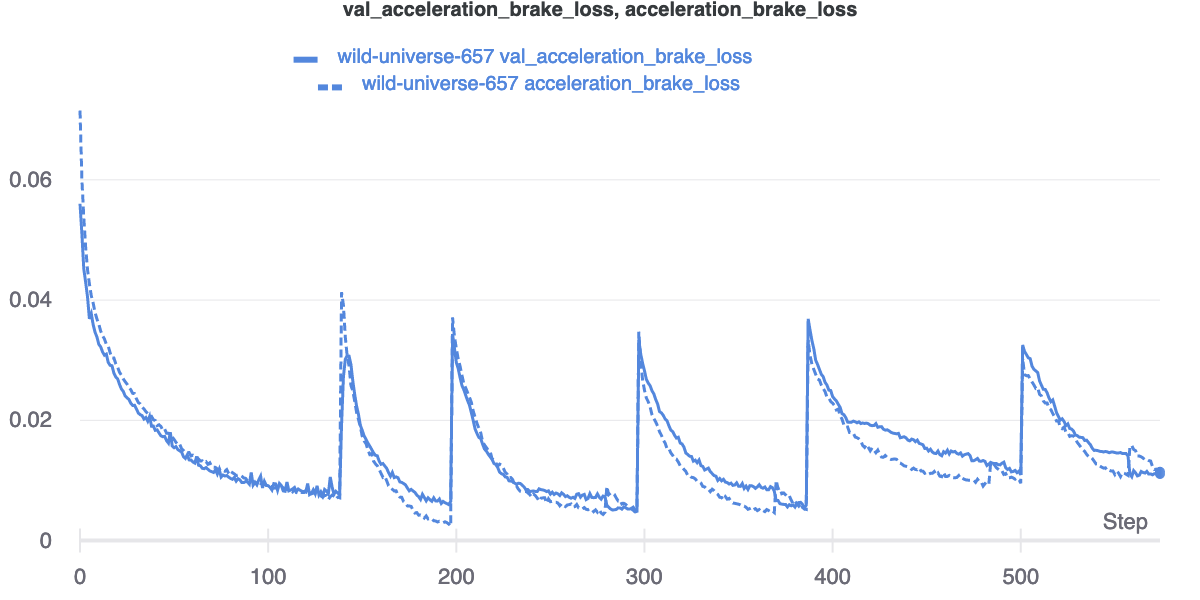